In [2]:
%matplotlib inline

import os
import time

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

from mpl_toolkits.basemap import Basemap

import netCDF4 as nc

from six.moves import urllib # six is for Python 2/3 compatibility

from pycurrents.codas import to_day
from pycurrents.num import rangeslice
from pycurrents.num import eof
# https://currents.soest.hawaii.edu/ocn_data_analysis/installation.html



In [11]:
lsmasknc = nc.Dataset('lsmask_pacific_regrid.nc')
seamask = lsmasknc.variables['mask'][0].astype(bool)
lsmasknc.close()
landmask = np.logical_not(seamask)
print(landmask.shape)

sstnc = nc.Dataset('sst_ocean_1951_2300_yearmean_1_pacific.nc')

# Read all the 1-D dimensional arrays.
time = sstnc.variables['time'][:]
lat = sstnc.variables['yt_ocean'][:]                       
lon = sstnc.variables['xt_ocean'][:]

# Read the 3-D SST array, and mask it.
sst = np.ma.array(sstnc.variables['sst'][:])
sst[:, landmask] = np.ma.masked
sstnc.close()
time = time/8760+1849

(47, 160)


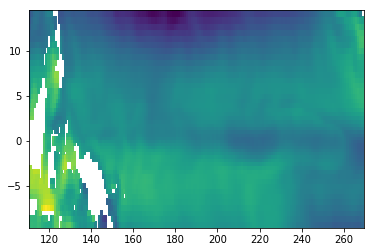

In [12]:
plt.pcolormesh(lon,lat,sst[10])

In [13]:
sstmean = sst.mean(axis=0)
sstdm = sst - sstmean

sstdmz = sstdm.filled(0)

In [14]:
latweights = np.sqrt(np.cos(np.deg2rad(lat)))
latweights = latweights[np.newaxis, :, np.newaxis]
sstdmz *= latweights

In [15]:
ssteof = eof.EOF(sstdmz)

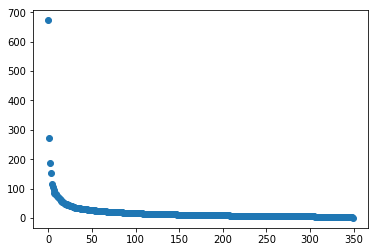

In [16]:
fig, ax = plt.subplots()
ax.plot(ssteof.s, 'o')
ax.margins(0.05)

[60.02859193  9.76597782  4.54948502  3.12349153  1.80713702  1.43242803
  1.18288332  0.97191903  0.8951415   0.8438456 ]


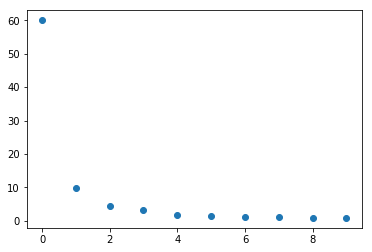

In [17]:
fig, ax = plt.subplots()
ax.plot(ssteof.percent_var()[:10], 'o')
print(ssteof.percent_var()[:10])

In [18]:
pats = np.ma.array(ssteof.v_reshaped)
pats[:, landmask] = np.ma.masked
pats /= latweights
pats = pats *  ssteof.s[:, np.newaxis, np.newaxis]

In [19]:
cmap = plt.get_cmap('RdBu_r')

In [24]:
# quick and dirty: using global pats and ssteof
def contour_pattern(i):
    # normalize so that std of time function is unity, and pattern
    # is in degrees.
    std_t = ssteof.u[:, i].std()
    pat = pats[i] * std_t
    mag = pat.std()
    cticker = mpl.ticker.MaxNLocator(nbins=30, symmetric=True)
    cticker.create_dummy_axis()
    cticker.set_bounds(-2*mag, 2*mag)
    clevs = cticker()

    fig, ax = plt.subplots(figsize=(20,10))
    cs = ax.contourf(lon, lat, -pat, levels=clevs,
                 cmap=cmap,
                 extend='both')
    ax.patch.set_facecolor('gray')
    fig.colorbar(cs, ax=ax, shrink=0.9)

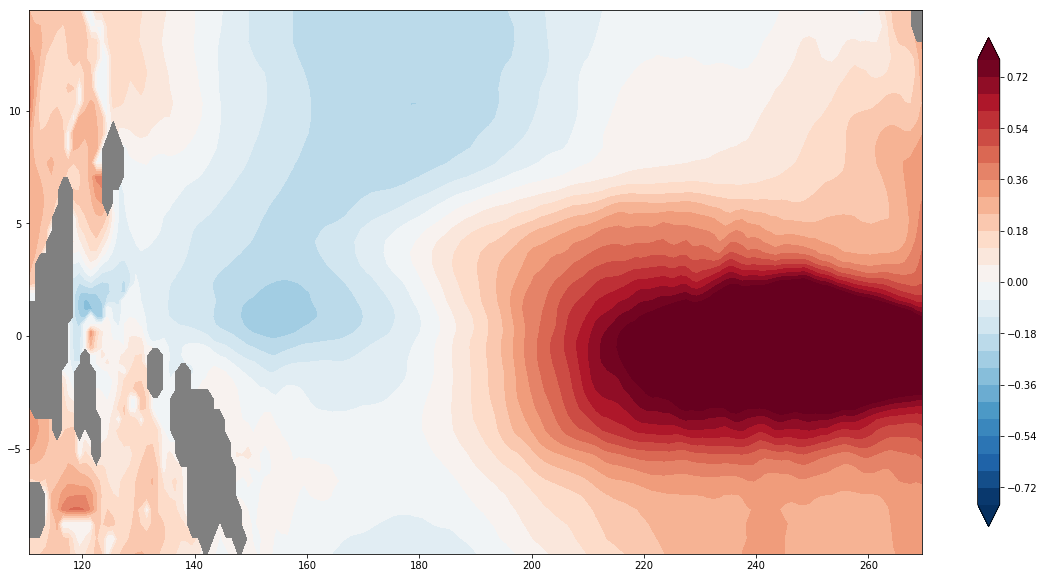

In [25]:
contour_pattern(0)

In [26]:
gmap = Basemap(lon_0=180, projection="kav7", resolution='c')
X, Y = gmap(*np.meshgrid(lon, lat))
def draw_map(gmap, ax):
    gmap.drawmapboundary(ax=ax)
    gmap.drawcoastlines(ax=ax)
    gmap.fillcontinents(ax=ax)
    gmap.drawmeridians(np.arange(0, 360.01, 30), ax=ax)
    gmap.drawparallels(np.arange(-60, 60.01, 30), ax=ax)

In [39]:
def map_pattern(i, pats, ssteof, yeartime, gmap):
    # normalize so that std of time function is unity, and pattern
    # is in degrees.
    std_t = ssteof.u[:, i].std()
    pat = pats[i] * std_t
    mag = pat.std()
    cticker = mpl.ticker.MaxNLocator(nbins=30, symmetric=True)
    cticker.create_dummy_axis()
    cticker.set_bounds(-2*mag, 2*mag)
    clevs = cticker()

    #fig, ax = plt.subplots()
    #cs = ax.contourf(lon, lat, pat, levels=clevs,
    #             cmap=cmap,
    #             extend='both')
    #fig.colorbar(cs, ax=ax, shrink=0.9)

    fig, axs = plt.subplots(nrows=2, figsize=(20, 10))
    
    draw_map(gmap, ax=axs[1])
    cs = gmap.contourf(X, Y, -pat, levels=clevs, 
                   cmap=cmap,
                   extend='both', ax=axs[1])
    cbar = fig.colorbar(cs, ax=axs[1], orientation='vertical',
                        shrink=0.8,
                        ticks=plt.MaxNLocator(nbins=6, symmetric=True))
    cbar.set_label('$^\circ$C')
    ax = axs[0]
    ax.grid()
    ax.plot(yeartime, ssteof.u[:, i] / std_t)
    np.savetxt('pc1.txt', ssteof.u[:, i] / std_t, delimiter=',')
    ax.set_title("EOF %d: %.1f%% of variance" % 
                 (i, ssteof.percent_var()[i]))

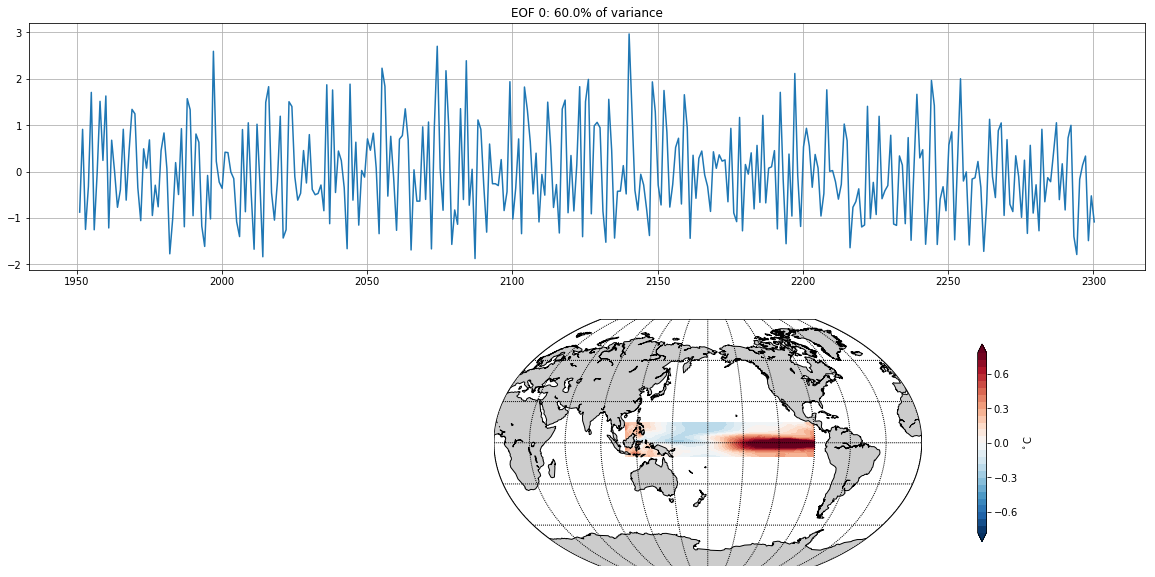

In [40]:
for i in range(1):
    map_pattern(i, pats, ssteof, time, gmap)
plt.savefig('sst_eof.png')